In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

tf.__version__
tf.keras.__version__

TensorFlow Version: 2.3.0
Default GPU Device: /device:GPU:0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


'2.4.0'

In [2]:
# library
import pandas as pd
import os 
import feather
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
from scipy.special import logsumexp
from sklearn import preprocessing
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from utils import *

In [3]:
# read in 
WU = feather.read_dataframe('Data/WU_lag.feather')

WU = WU.drop(columns=['Index','year','ParcelID','Days','year','month'])

WU_train = WU[WU['Set'] == 'train'].drop(columns=['Set'])
WU_dev = WU[WU['Set'] == 'dev'].drop(columns=['Set'])
WU_test = WU[WU['Set'] == 'test'].drop(columns=['Set'])

WU_train_all =  WU[WU['Set'] != 'test'].drop(columns=['Set'])

predictors = list( WU_train.drop(columns=['TotalWaterUse']).columns)

X_train1 = WU_train.drop(columns=['TotalWaterUse']).values
Y_train = WU_train.loc[:,'TotalWaterUse'].values

X_dev1 = WU_dev.drop(columns=['TotalWaterUse']).values
Y_dev = WU_dev.loc[:,'TotalWaterUse'].values

X_test1 = WU_test.drop(columns=['TotalWaterUse']).values
Y_test = WU_test.loc[:,'TotalWaterUse'].values

X_train_all1 = WU_train_all.drop(columns=['TotalWaterUse']).values
Y_train_all = WU_train_all.loc[:,'TotalWaterUse'].values

p_scalar1 = preprocessing.StandardScaler() # for dev
p_scalar2 = preprocessing.StandardScaler() # for test
p_scalar1.fit(X_train1)
p_scalar2.fit(X_train_all1)

X_train = p_scalar1.transform(X_train1 )
X_dev = p_scalar1.transform(X_dev1)

X_train_all = p_scalar2.transform(X_train_all1)
X_test = p_scalar2.transform(X_test1 )

In [4]:
def buildmodel(dense_dp = 0.1, l2=0.01, unites =128):
    model = keras.models.Sequential([
        keras.layers.Dense(unites,activation='selu', input_shape = X_train.shape[1:], 
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp),
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),
        keras.layers.Dropout(dense_dp) ,
        keras.layers.Dense(unites,activation='selu',
                                 kernel_initializer='lecun_normal',
                                 kernel_regularizer=keras.regularizers.l2(l2)),

       #keras.layers.AlphaDropout(dense_dp) ,
        keras.layers.Dense(1)
    ])
    return model

del model
tf.keras.backend.clear_session()

In [5]:
l2 = 0.1
dp_rate=0.1
n_unites = 512
lr=1e-5
batch_size=128

In [6]:
model = buildmodel(dense_dp = dp_rate, l2=l2, unites = n_unites)

model.compile(optimizer = keras.optimizers.Nadam(learning_rate=lr), loss = 'mean_squared_error', metrics = ['mse'] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               10240     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

In [8]:
callback_list =[
    keras.callbacks.EarlyStopping(
        monitor = 'val_mse',
        restore_best_weights=True,
        patience= 5
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='MLP_log/mpl_mc_dev_1m.h5',
        save_best_only= True,
        monitor='val_mse'
    )
]

In [9]:
# seed
tf.random.set_seed(1)
np.random.seed(1)

history = model.fit(x= X_train,
                    y= Y_train,
                    epochs= 100,
                    batch_size= batch_size,
                    validation_data=( X_dev,Y_dev),
                    callbacks=callback_list)

Epoch 1/100
85/85 [==============================] - 1s 13ms/step - loss: 33053370.0000 - mse: 33053008.0000 - val_loss: 32948808.0000 - val_mse: 32948450.0000
Epoch 2/100
85/85 [==============================] - 1s 10ms/step - loss: 32845554.0000 - mse: 32845208.0000 - val_loss: 32562786.0000 - val_mse: 32562428.0000
Epoch 3/100
85/85 [==============================] - 1s 9ms/step - loss: 31967580.0000 - mse: 31967214.0000 - val_loss: 30819020.0000 - val_mse: 30818656.0000
Epoch 4/100
85/85 [==============================] - 1s 9ms/step - loss: 27854134.0000 - mse: 27853774.0000 - val_loss: 23359898.0000 - val_mse: 23359536.0000
Epoch 5/100
85/85 [==============================] - 1s 9ms/step - loss: 16374421.0000 - mse: 16374057.0000 - val_loss: 10731551.0000 - val_mse: 10731188.0000
Epoch 6/100
85/85 [==============================] - 1s 9ms/step - loss: 8528611.0000 - mse: 8528249.0000 - val_loss: 8604171.0000 - val_mse: 8603806.0000
Epoch 7/100
85/85 [=============================

85/85 [==============================] - 1s 9ms/step - loss: 1979956.5000 - mse: 1979566.2500 - val_loss: 2049785.0000 - val_mse: 2049395.0000
Epoch 54/100
85/85 [==============================] - 1s 9ms/step - loss: 1947777.8750 - mse: 1947387.5000 - val_loss: 2050467.3750 - val_mse: 2050077.2500
Epoch 55/100
85/85 [==============================] - 1s 10ms/step - loss: 1953796.0000 - mse: 1953405.0000 - val_loss: 2020639.6250 - val_mse: 2020248.7500
Epoch 56/100
85/85 [==============================] - 1s 11ms/step - loss: 1908435.6250 - mse: 1908045.1250 - val_loss: 1983810.7500 - val_mse: 1983419.5000
Epoch 57/100
85/85 [==============================] - 1s 9ms/step - loss: 1912765.8750 - mse: 1912374.3750 - val_loss: 1996873.6250 - val_mse: 1996482.1250
Epoch 58/100
85/85 [==============================] - 1s 9ms/step - loss: 1865179.6250 - mse: 1864787.3750 - val_loss: 2005771.7500 - val_mse: 2005380.0000
Epoch 59/100
85/85 [==============================] - 1s 9ms/step - loss: 1

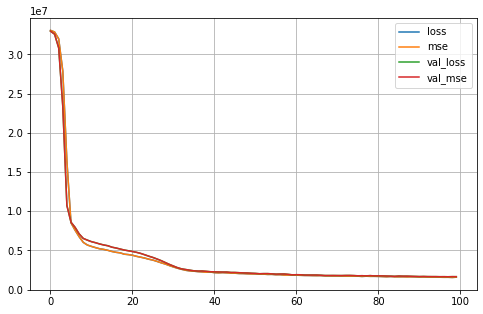

In [10]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

plt.show()

In [11]:
pred = model.predict(X_dev)
y_true = Y_dev

In [12]:
stop_epoch = pd.Series(history.history['val_mse'],index = history.epoch).idxmin()

In [13]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

mc_model = keras.models.Sequential([
    MCDropout(dp_rate) if isinstance(layer, keras.layers.Dropout) else layer
    for layer in model.layers
])

mc_model.compile(optimizer = keras.optimizers.Nadam(learning_rate=lr), loss = 'mean_squared_error', metrics = ['mse'] )
mc_model.set_weights(model.get_weights())


X_test_tf = tf.constant( X_dev, dtype=tf.float32 )
T= 1000
y_probas = np.stack([mc_model.predict(X_test_tf, batch_size= batch_size)
                     for sample in range(T)])
print('done')

done


In [14]:
y_hat_MC = y_probas.reshape(y_probas.shape[:-1])
y_hat = y_hat_MC.mean(axis=0)
sig_hat = y_hat_MC.std(axis=0)
y_true = Y_dev

# Tune tau

In [15]:
grid_ll = []
taul, tl = [], []
for t in range(100):
    tau = 2**(-t)
    ll = (logsumexp(-0.5 * tau * (y_true - y_hat_MC)**2., 0) - np.log(T) - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
    test_ll = np.mean(ll)
    taul.append(tau)
    grid_ll.append(test_ll)
    tl.append(t)
best_t = tl[grid_ll.index(max(grid_ll))]
best_tau = taul[grid_ll.index(max(grid_ll))]
best_tau, best_t, max(grid_ll)


G = 100
gg = (taul[grid_ll.index(max(grid_ll))-1] - taul[grid_ll.index(max(grid_ll))+1])/G
grid_ll = []
taul, tl = [], []
for t in range(G):
    tau = 2**(-best_t-1) +  gg*t
    ll = (logsumexp(-0.5 * tau * (y_true - y_hat_MC)**2., 0) - np.log(T) - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
    test_ll = np.mean(ll)
    taul.append(tau)
    grid_ll.append(test_ll)
    tl.append(t)
    

rmse = round(np.sqrt(mean_squared_error(y_true,y_hat)),4) 

best_t = tl[grid_ll.index(max(grid_ll))]
best_tau = taul[grid_ll.index(max(grid_ll))]
sig = np.sqrt(1/best_tau)
print('final tune value: tau:{} t:{} LL:{} RMSE:{}'.format(best_tau, best_t, max(grid_ll),rmse ))

final tune value: tau:7.62939453125e-07 t:20 LL:-8.528655524666021 RMSE:1255.2121


In [16]:
sig = np.sqrt(1/best_tau)

In [17]:
# hyper-par: tau
np.random.seed(1)
y_MC_mixture = np.concatenate([np.random.normal(loc=samplei,scale=sig,size=(10,len(samplei))) for samplei in y_hat_MC] , axis=0)

In [18]:
alpha= 0.05
L_hat = np.quantile(y_MC_mixture,alpha/2,axis=0)
U_hat = np.quantile(y_MC_mixture,(1-alpha/2),axis=0)

left = L_hat
right = U_hat
py_all = np.stack([norm.pdf(y_true, loc=samplei, scale=sig) for samplei in y_hat_MC])
p_y = py_all.mean(axis=0)
sig_hat2 = y_MC_mixture.std(axis=0)

# save to dev MF

In [19]:
WU2 = feather.read_dataframe('Data/WU_lag.feather')
all_dev_MF = pd.DataFrame({
    'Index': WU2[WU2.loc[:,'Set']=='dev'].loc[:,'Index'].values,
    'Y': y_true,
    'y_hat': y_hat,
    'L': left,
    'U': right,
    'sig_hat': sig_hat2,
    'p_y':p_y
})
path = 'Out_dev_MF\\month1\\MLP_MC_dev_1m_dist.feather'

feather.write_dataframe(all_dev_MF , path)

In [20]:
del model
tf.keras.backend.clear_session()

# Test

In [21]:
model = buildmodel(dense_dp = dp_rate, l2=0.1, unites = n_unites)
model.compile(optimizer = keras.optimizers.Nadam(learning_rate=lr), loss = 'mean_squared_error', metrics = ['mse'] )

In [23]:
from tensorflow.keras import utils
from tensorflow.keras import callbacks

callback_list =[
    callbacks.EarlyStopping(
        monitor = 'val_mse',
        patience= stop_epoch
    ),
    callbacks.ModelCheckpoint(
        filepath='MLP_log/mlp_mc_1m.h5',
        #save_best_only= True,
        monitor='val_mse'
    )
]

In [24]:
# seed
tf.random.set_seed(1)
np.random.seed(1)
history = model.fit(x= X_train_all,
                    y= Y_train_all,
                    epochs= stop_epoch,
                    batch_size= batch_size,
                    validation_data=( X_test,Y_test),
                    callbacks=callback_list)


Epoch 1/97
94/94 [==============================] - 1s 10ms/step - loss: 33038838.0000 - mse: 33038478.0000 - val_loss: 30801398.0000 - val_mse: 30801040.0000
Epoch 2/97
94/94 [==============================] - 1s 10ms/step - loss: 32747820.0000 - mse: 32747462.0000 - val_loss: 30267248.0000 - val_mse: 30266886.0000
Epoch 3/97
94/94 [==============================] - 1s 9ms/step - loss: 31031348.0000 - mse: 31030988.0000 - val_loss: 26837544.0000 - val_mse: 26837184.0000
Epoch 4/97
94/94 [==============================] - 1s 10ms/step - loss: 22318204.0000 - mse: 22317842.0000 - val_loss: 14244919.0000 - val_mse: 14244556.0000
Epoch 5/97
94/94 [==============================] - 1s 9ms/step - loss: 9853041.0000 - mse: 9852677.0000 - val_loss: 8899354.0000 - val_mse: 8898989.0000
Epoch 6/97
94/94 [==============================] - 1s 9ms/step - loss: 7860962.5000 - mse: 7860599.0000 - val_loss: 8191229.5000 - val_mse: 8190864.0000
Epoch 7/97
94/94 [==============================] - 1s 9m

Epoch 54/97
94/94 [==============================] - 1s 11ms/step - loss: 1912776.0000 - mse: 1912383.8750 - val_loss: 1936704.6250 - val_mse: 1936312.5000
Epoch 55/97
94/94 [==============================] - 1s 11ms/step - loss: 1935720.5000 - mse: 1935327.3750 - val_loss: 1927418.8750 - val_mse: 1927025.8750
Epoch 56/97
94/94 [==============================] - 1s 11ms/step - loss: 1880055.5000 - mse: 1879662.1250 - val_loss: 1872977.7500 - val_mse: 1872584.7500
Epoch 57/97
94/94 [==============================] - 1s 11ms/step - loss: 1900392.7500 - mse: 1899999.2500 - val_loss: 1889267.6250 - val_mse: 1888874.5000
Epoch 58/97
94/94 [==============================] - 1s 10ms/step - loss: 1868335.2500 - mse: 1867942.3750 - val_loss: 1882018.5000 - val_mse: 1881624.5000
Epoch 59/97
94/94 [==============================] - 1s 10ms/step - loss: 1875510.6250 - mse: 1875116.2500 - val_loss: 1882713.0000 - val_mse: 1882318.2500
Epoch 60/97
94/94 [==============================] - ETA: 0s - l

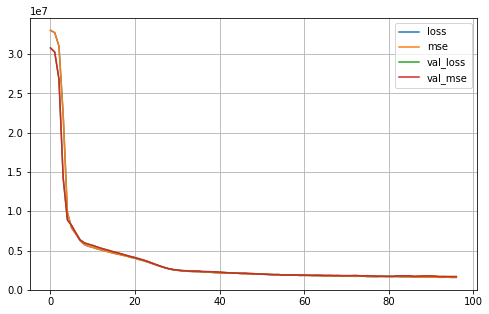

In [25]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [26]:
pred = model.predict(X_test)
y_true = Y_test
X_test_tf = tf.constant( X_test, dtype=tf.float32 )

In [27]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

mc_model = keras.models.Sequential([
    MCDropout(dp_rate) if isinstance(layer, keras.layers.Dropout) else layer
    for layer in model.layers
])

mc_model.compile(optimizer = keras.optimizers.Nadam(learning_rate=lr), loss = 'mean_squared_error', metrics = ['mse'] )
mc_model.set_weights(model.get_weights())


In [28]:
T= 1000
y_probas = np.stack([mc_model.predict(X_test_tf, batch_size= batch_size)
                     for sample in range(T)])
print('done')

done


In [29]:
y_hat_MC = y_probas.reshape(y_probas.shape[:-1])
y_hat = y_hat_MC.mean(axis=0)
sig_hat = y_hat_MC.std(axis=0)
y_true = Y_test
y_MC_mixture = np.concatenate([np.random.normal(loc=samplei,scale=sig,size=(10,len(samplei))) for samplei in y_hat_MC] , axis=0)

In [30]:
alpha= 0.05
L_hat = np.quantile(y_MC_mixture,alpha/2,axis=0)
U_hat = np.quantile(y_MC_mixture,(1-alpha/2),axis=0)

left = L_hat
right = U_hat
py_all = np.stack([norm.pdf(y_true, loc=samplei, scale=sig) for samplei in y_hat_MC])
p_y = py_all.mean(axis=0)
sig_hat2 = y_MC_mixture.std(axis=0)

# Save


In [31]:
WU2 = feather.read_dataframe('Data/WU_lag.feather')

all_test_MF= pd.DataFrame({
    'Index': WU2[WU2.loc[:,'Set']=='test'].loc[:,'Index'].values,
    'Y': y_true,
    'y_hat': y_hat,
    'L': left,
    'U': right,
    'sig_hat': sig_hat2,
    'p_y':p_y
})


path = 'Out_test_MF\\month1\\MLP_MC_1m_dist.feather'
feather.write_dataframe(all_test_MF , path)

path = 'Out_test_MF\\month1\\MLP_MC.npy'
np.save(path, y_MC_mixture)

# report

In [32]:
r1,r2,r3,r4,r5 = get_RMSE_NLL_NOIS_AWPI_ECPI(y_true,y_hat,left,right,alpha=0.05)

 & 1269.11 & 8.54 & 6958.25 & 4782.61 & 0.93 & 95\% \\


In [33]:
# results
with open("Results/Results_1m.txt", "a") as myfile:
    myfile.write("MLP_MC \n")
    myfile.write('RMSE %f & NLL %f & NOIS %f & AWPI %f & ECPI %f \n' % (
        r1,-np.log(p_y).mean(),r3,r4,r5 ))